## `Import Library what we need`

In [1]:
# BASED
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import pickle

# KERAS
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from keras.models import load_model
from keras.backend import clear_session


# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# SASTRAWI
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import  StopWordRemoverFactory

# WORD2VEC
import gensim

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 100
EPOCHS = 50
BATCH_SIZE = 1024

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\whisn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\whisn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\whisn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Stopwords
nltk_stopwords = stopwords.words('indonesian')
sastrawi_factory = StopWordRemoverFactory()

# Stemming
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

# Tokenizer
tokenizer = Tokenizer()

## `Function`

In [29]:
# Tokenize
def tokenize(text):
    return text.split()


# Stopwords 
def stopwords_text(tokens): 
    cleaned_tokens = []
    for token in tokens : 
        if token not in sastrawi_stopwords: 
            cleaned_tokens.append(token)
    return cleaned_tokens


# Stemming
def stem_words(tokens):
  hasil = [stemmer.stem(token) for token in tokens]
  return hasil


# Untokenize
def untokenize(texts):
    text = ""
    for i in texts:
        text += f"{i}"
        text += " "
    return text.rstrip()


# Encoding
def manual_label_encoder(labels):
    label_index = {'positif': 1, 'negatif': 0}  # Membuat kamus untuk mapping label
    encoded_labels = [label_index[label] for label in labels]  # Encoding label
    return encoded_labels, label_index


def reshape_labels(encoded_labels):
    reshaped_labels = [[label] for label in encoded_labels]  # Reshape array hasil encoding ke bentuk (jumlah_data, 1)
    return reshaped_labels


# Normalize label Text
def normalize_label(df):
    df['label'] = df['label'].str.strip().str.lower()
    df['label'] = df['label'].replace('netral', 'negatif')
    return df


# Create 1D Array from 2D Array
def merge_2d_array_to_1d(df_column):
    merged = [word for sublist in df_column for word in sublist]
    return merged


# Create Word Freq
def word_freq_func(data, label):
    # Menghitung frekuensi kemunculan setiap kata dan kolom 'label'
    word_freq = {}
    for word, label in zip(data, label):
        if word in word_freq:
            if label == 'positif':
                word_freq[word][0] += 1
            else:
                word_freq[word][1] += 1
        else:
            if label == 'positif':
                word_freq[word] = [1, 0]
            else:
                word_freq[word] = [0, 1]
    return word_freq


# Tokenize Column
def tokenize_column(dataframe, column_name):
    tokenized_documents = [text.split() for text in dataframe[column_name]]
    return tokenized_documents


# Calculate Similarity
def calculate_similarity(keyword, w2v_model):
    similarities = []
    # Melakukan iterasi pada setiap kata dalam model
    for word in w2v_model.wv.index_to_key:
        # Menangkap pengecualian jika kata tidak ada dalam model
        try:
            # Menghitung kemiripan antara kata dalam kosakata dengan kata kunci
            similarity = w2v_model.wv.similarity(keyword, word)      
            # Menambahkan ke list similarities
            similarities.append((word, similarity))
        except KeyError:
            # Tangani jika kata tidak ditemukan dalam model
            print(f"Word '{word}' not in vocabulary.")
    # Buat DataFrame dari list similarities
    df = pd.DataFrame(similarities, columns=['Keyword', 'Similarity'])
    # Sorting DataFrame secara descending berdasarkan similarity
    df = df.sort_values(by='Similarity', ascending=False)
    return df


# Get n Items from Dictionary
def get_top_n_items(dictionary, n, seq):
    # Mengambil n item teratas dari dictionary berdasarkan frekuensi kemunculan
    top_n = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=seq)[:n])
    return top_n

# Create Embedding Matrix
def create_embedding_matrix(vocab_size, tokenizer, w2v_model):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))

    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

    return embedding_matrix


def manual_evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_binary = (y_pred > 0.5).astype('int32')  # Konversi probabilitas menjadi nilai biner

    accuracy = tensorflow.reduce_mean(tensorflow.cast(y_pred_binary == y_test, tensorflow.float32))  # Menghitung akurasi dari perbandingan boolean
    return accuracy


def display_confusion_heatmap(y_test, y_preds, model_names):
    num_models = len(y_preds)
    num_rows = num_models // 2 + num_models % 2  # Hitung jumlah baris berdasarkan jumlah model
    plt.figure(figsize=(12, 8))  # Atur ukuran gambar secara keseluruhan
    for i, y_pred in enumerate(y_preds):
        # Hitung TP, TN, FP, FN
        TP, TN, FP, FN = manual_heatmap(y_test, y_pred)

        # Bentuk matrix confusion
        confusion_matrix = [[TN, FP], [FN, TP]]

        # label untuk heatmap
        labels = [['TN', 'FP'], ['FN', 'TP']]

        # Plot heatmap dalam subplot
        plt.subplot(num_rows, 2, i + 1)
        sns.heatmap(confusion_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

        # Menambahkan label ke heatmap
        for j in range(2):
            for k in range(2):
                plt.text(k + 0.5, j + 0.5, str(labels[j][k]) + " = " + str(confusion_matrix[j][k]), ha='center', va='center', color='black')

        plt.title(f'Confusion Matrix - {model_names[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    
    plt.tight_layout()  # Menata layout subplot agar rapi
    plt.show()

def manual_heatmap(y_test, y_pred):
    # Menginisialisasi variabel untuk TP, TN, FP, FN
    TP, TN, FP, FN = 0, 0, 0, 0
    
    # Menghitung TP, TN, FP, FN
    for actual, pred in zip(y_test, y_pred):
        if actual == "positif" and pred == "positif":
            TP += 1
        elif actual == "negatif" and pred == "negatif":
            TN += 1
        elif actual == "negatif" and pred == "positif":
            FP += 1
        elif actual == "positif" and pred == "negatif":
            FN += 1
    
    return TP, TN, FP, FN


def check_test_accuracy(y_pred, y_test):
    # Menghitung jumlah prediksi yang benar (True)
    correct_predictions = sum(1 for pred, actual in zip(y_pred, y_test) if pred == actual)

    # Menghitung akurasi
    total_predictions = len(y_pred)
    accuracy = correct_predictions / total_predictions
    return accuracy


def create_lstm_model(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [435]:
class CustomLSTM(tensorflow.keras.layers.Layer):
    def __init__(self, units, dropout, recurrent_dropout):
        super(CustomLSTM, self).__init__()
        self.units = units
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout

    def build(self, input_shape):
        self.input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(self.input_dim + self.units, 4 * self.units),
            initializer='glorot_uniform',
            name='kernel'
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, 4 * self.units),
            initializer='orthogonal',
            name='recurrent_kernel'
        )
        self.bias = self.add_weight(
            shape=(4 * self.units,),
            initializer='zeros',
            name='bias'
        )
        self.built = True

    def call(self, inputs, states=None, training=None):
        h_tm1 = states[0] if states else tensorflow.zeros((tensorflow.shape(inputs)[0], self.units))
        c_tm1 = states[1] if states else tensorflow.zeros((tensorflow.shape(inputs)[0], self.units))

        if training is None:
            training = tensorflow.keras.backend.learning_phase()

        if 0 < self.dropout < 1 and self.dropout is not None:
            inputs = tensorflow.keras.layers.Dropout(self.dropout)(inputs, training=training)

        concat_inputs = tensorflow.concat([inputs, h_tm1], axis=-1)
        gate_inputs = tensorflow.matmul(concat_inputs, self.kernel) + self.bias

        i, f, g, o = tensorflow.split(gate_inputs, 4, axis=-1)
        i = tensorflow.sigmoid(i)
        f = tensorflow.sigmoid(f)
        g = tensorflow.tanh(g)
        o = tensorflow.sigmoid(o)

        c = f * c_tm1 + i * g

        if 0 < self.recurrent_dropout < 1 and self.recurrent_dropout is not None:
            c = tensorflow.keras.layers.Dropout(self.recurrent_dropout)(c, training=training)

        h = o * tensorflow.tanh(c)

        return h, [h, c]

    def get_config(self):
        config = super().get_config()
        config.update({
            'units': self.units,
            'dropout': self.dropout,
            'recurrent_dropout': self.recurrent_dropout
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


### `Read Data`

In [9]:
df1 = pd.read_csv('./dataset/data-label.csv')
df1 = df1.rename(columns={'label':'label'})
copy_df1 = df1.copy()
df1.head()

,full_text,text_clean,label
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,netral
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,positif
2,Keputusan mantan Kepala Desa: Prabowo-Gibran a...,keputusan mantan kepala desa prabowogibran ada...,positif
3,Ahmad dhani kampanye PRABOWO GIBRAN 🫰🫰🫰🫰🫰🫰🫰 ht...,ahmad dhani kampanye prabowo gibran,positif
4,Pilihan optimis Mantan Kepala Desa: Prabowo-Gi...,pilihan optimis mantan kepala desa prabowogibr...,positif


In [10]:
df2 = pd.read_csv('./dataset/external-label.csv')
copy_df2 = df2.copy()
df2.head()

,full_text,text_clean,label
0,"Presiden ke-6 Republik Indonesia, Susilo Bamba...",presiden ke republik indonesia susilo bambang ...,positif
1,Hal tersebut diungkapkan SBY dalam sambutannya...,hal tersebut diungkapkan sby dalam sambutannya...,positif
2,"Beliau adalah sahabat saya, beliau juga patrio...",beliau adalah sahabat saya beliau juga patriot...,positif
3,Sebagai mantan presiden yang telah memimpin In...,sebagai mantan presiden yang telah memimpin in...,positif
4,“Tangkapan di jagat maya saat ini Prabowo-Gibr...,tangkapan di jagat maya saat ini prabowogibran...,positif


In [11]:
df = pd.concat([df1, df2])
df.head()

,full_text,text_clean,label
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,netral
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,positif
2,Keputusan mantan Kepala Desa: Prabowo-Gibran a...,keputusan mantan kepala desa prabowogibran ada...,positif
3,Ahmad dhani kampanye PRABOWO GIBRAN 🫰🫰🫰🫰🫰🫰🫰 ht...,ahmad dhani kampanye prabowo gibran,positif
4,Pilihan optimis Mantan Kepala Desa: Prabowo-Gi...,pilihan optimis mantan kepala desa prabowogibr...,positif


In [12]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 13
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   full_text   890 non-null    object
 1   text_clean  890 non-null    object
 2   label       890 non-null    object
dtypes: object(3)
memory usage: 27.8+ KB


### `Tokenize`

In [13]:
df['token'] = df['text_clean'].apply(tokenize)
df.head(2)

,full_text,text_clean,label,token
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,netral,"[sumber, tiktok, tkn, prabowo, gibran]"
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,positif,"[solidaritas, positif, mantan, kepala, desa, p..."


### `Stopwords`

In [15]:
print(nltk_stopwords[:5])
print(len(nltk_stopwords))

['ada', 'adalah', 'adanya', 'adapun', 'agak']
758


In [16]:
sastrawi_stopwords = sastrawi_factory.get_stop_words()
print(sastrawi_stopwords[:5])
print(len(sastrawi_stopwords))

['yang', 'untuk', 'pada', 'ke', 'para']
126


In [17]:
df['stop'] = df['token'].apply(stopwords_text)
df.head(2)

,full_text,text_clean,label,token,stop
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,netral,"[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]"
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,positif,"[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p..."


### `Stemming`

In [18]:
df['stemmed'] = df['stop'].apply(stem_words)
df.head(2)

,full_text,text_clean,label,token,stop,stemmed
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,netral,"[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]"
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,positif,"[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p..."


In [22]:
df = df[['full_text', 'text_clean', 'token', 'stop', 'stemmed', 'label']]
df.head(2)

,full_text,text_clean,token,stop,stemmed,label
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,"[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]",netral
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,"[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...",positif


### `Exploratory Data Analysis`

In [30]:
df['label'].value_counts()

negatif    509
positif    380
netral       1
Name: label, dtype: int64

In [31]:
df = normalize_label(df)
print(df['label'].value_counts())

negatif    510
positif    380
Name: label, dtype: int64


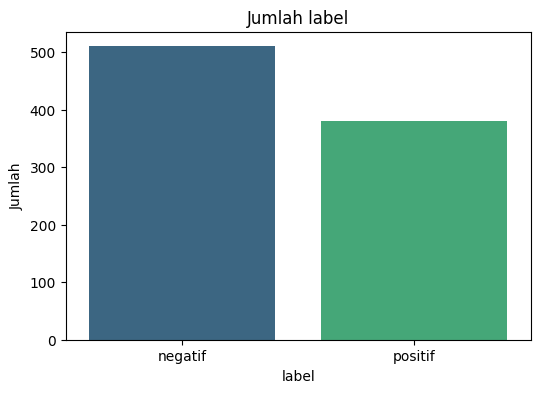

In [32]:
counts = df['label'].value_counts()
plt.figure(figsize=(6, 4))  # Mengatur ukuran plot

sns.barplot(x=counts.index, y=counts.values, palette='viridis')

plt.title('Jumlah label')
plt.xlabel('label')
plt.ylabel('Jumlah')

plt.show()

In [33]:
# Menggabungkan semua list menjadi satu list tunggal
merged_stemming = merge_2d_array_to_1d(df['stemmed'])
merged_stemming[:5]

['sumber', 'tiktok', 'tkn', 'prabowo', 'gibran']

In [34]:
word_freq = word_freq_func(merged_stemming, df['label'])
print(word_freq)

{'sumber': [0, 1], 'tiktok': [1, 0], 'tkn': [1, 0], 'prabowo': [20, 20], 'gibran': [17, 23], 'solidaritas': [1, 1], 'positif': [8, 3], 'mantan': [12, 15], 'kepala': [3, 4], 'desa': [7, 5], 'prabowogibran': [23, 19], 'langkah': [1, 0], 'maju': [1, 0], 'putus': [1, 1], 'jalan': [1, 0], 'ubah': [8, 7], 'ingin': [0, 2], 'ahmad': [0, 1], 'dhani': [1, 0], 'kampanye': [1, 0], 'pilih': [1, 5], 'optimis': [0, 1], 'pimpin': [8, 13], 'iring': [1, 1], 'suara': [2, 5], 'bulat': [0, 2], 'ratus': [4, 3], 'kades': [6, 9], 'bangun': [2, 2], 'nyata': [4, 2], 'cipta': [3, 1], 'harmoni': [0, 1], 'dukung': [7, 14], 'pilpres': [2, 3], 'satu': [1, 4], 'lebih': [5, 2], 'baik': [2, 3], 'sama': [1, 3], 'komitmen': [1, 1], 'percaya': [1, 0], 'narasi': [1, 0], 'penuh': [1, 1], 'solusi': [1, 0], 'semangat': [2, 2], 'segar': [1, 0], 'kotakabupaten': [1, 2], 'cirebon': [7, 5], 'buat': [1, 1], 'atmosfer': [1, 0], 'katalisator': [1, 0], 'mentang': [1, 0], 'jadi': [1, 2], 'caprescawapres': [0, 1], 'terus': [1, 1], 'ser

In [35]:
# Membuat DataFrame dari hasil perhitungan frekuensi kata dan kolom 'label'
df_word_freq = pd.DataFrame(word_freq.items(), columns=['Kata', 'Jumlah'])
df_word_freq[['Jumlah_Positif', 'Jumlah_Negatif']] = pd.DataFrame(df_word_freq['Jumlah'].tolist(), index=df_word_freq.index)
df_word_freq.drop('Jumlah', axis=1, inplace=True)
df_word_freq.head()

,Kata,Jumlah_Positif,Jumlah_Negatif
0,sumber,0,1
1,tiktok,1,0
2,tkn,1,0
3,prabowo,20,20
4,gibran,17,23


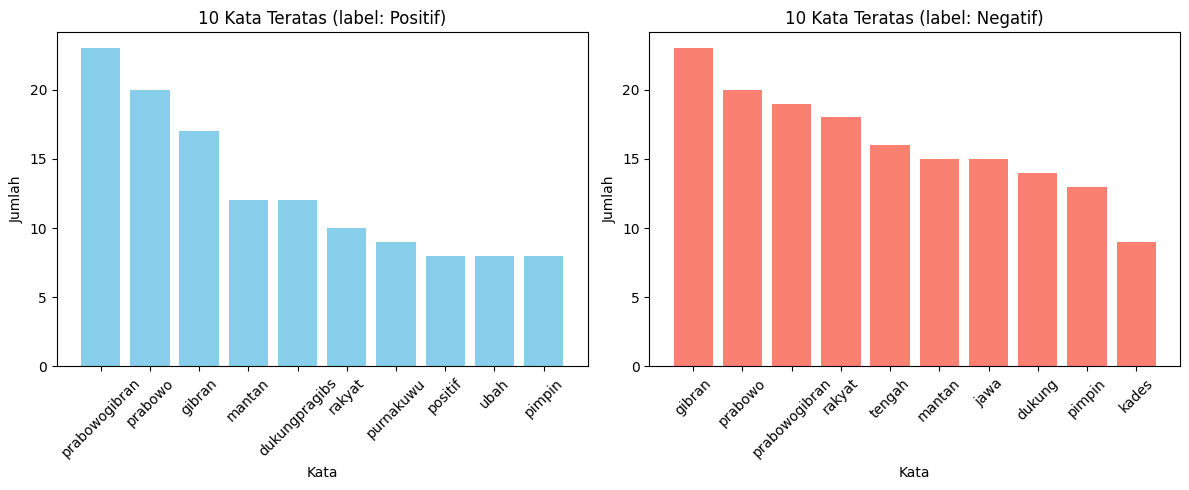

In [36]:
# Mengambil 10 kata teratas untuk masing-masing label
top_positif = df_word_freq.nlargest(10, 'Jumlah_Positif')
top_negatif = df_word_freq.nlargest(10, 'Jumlah_Negatif')

# Plot bar chart untuk 10 kata teratas masing-masing label
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(top_positif['Kata'], top_positif['Jumlah_Positif'], color='skyblue')
plt.title('10 Kata Teratas (label: Positif)')
plt.xticks(rotation=45)
plt.xlabel('Kata')
plt.ylabel('Jumlah')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.bar(top_negatif['Kata'], top_negatif['Jumlah_Negatif'], color='salmon')
plt.title('10 Kata Teratas (label: Negatif)')
plt.xticks(rotation=45)
plt.xlabel('Kata')
plt.ylabel('Jumlah')
plt.tight_layout()

plt.show()

### `WORD2VEC MODEL`

In [37]:
df.head(2)

,full_text,text_clean,token,stop,stemmed,label
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,"[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]",negatif
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,"[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...",positif


In [38]:
df['untokenize_clean'] = df['stemmed'].apply(untokenize)
df = df[['full_text', 'text_clean', 'token', 'stop', 'stemmed','untokenize_clean', 'label']]
df.head(2)

,full_text,text_clean,token,stop,stemmed,untokenize_clean,label
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,"[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]",sumber tiktok tkn prabowo gibran,negatif
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,"[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...",solidaritas positif mantan kepala desa prabowo...,positif


In [39]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
print("Train size:", len(df_train))
print("Test size:", len(df_test))

Train size: 623
Test size: 267


In [40]:
df_train.head(2)

,full_text,text_clean,token,stop,stemmed,untokenize_clean,label
490,Masyarakat Jatim melihat Ganjar sebagai pemimp...,masyarakat jatim melihat ganjar sebagai pemimp...,"[masyarakat, jatim, melihat, ganjar, sebagai, ...","[masyarakat, jatim, melihat, ganjar, pemimpin,...","[masyarakat, jatim, lihat, ganjar, pimpin, leb...",masyarakat jatim lihat ganjar pimpin lebih mil...,negatif
297,@ilhamram_dani Mantap banget! Gas terus dukung...,mantap banget gas terus dukung prabowogibran p...,"[mantap, banget, gas, terus, dukung, prabowogi...","[mantap, banget, gas, terus, dukung, prabowogi...","[mantap, banget, gas, terus, dukung, prabowogi...",mantap banget gas terus dukung prabowogibran b...,positif


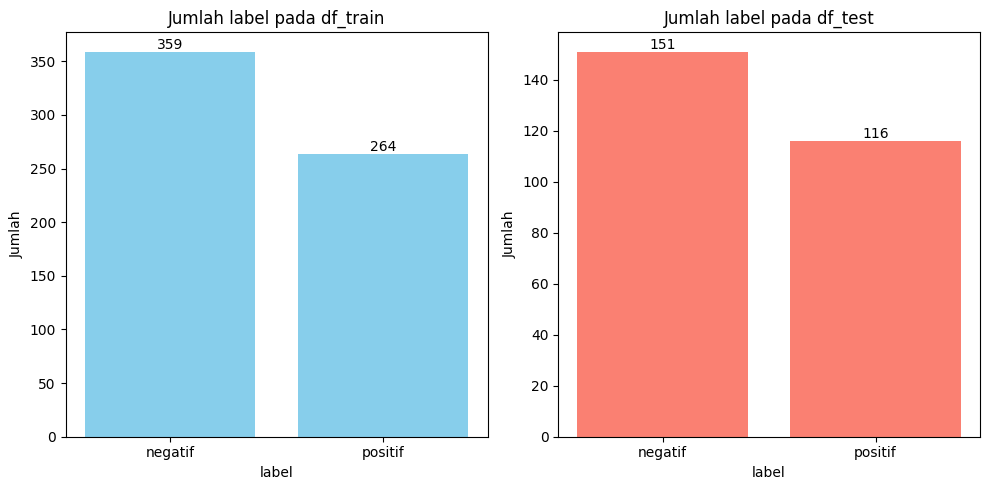

In [41]:
# Menghitung jumlah label untuk setiap nilai unik dalam kolom 'label' pada df_train dan df_test
train_label_counts = df_train.groupby('label').size()
test_label_counts = df_test.groupby('label').size()

# Data train dan test
data = [train_label_counts, test_label_counts]
titles = ['Jumlah label pada df_train', 'Jumlah label pada df_test']
colors = ['skyblue', 'salmon']

# Menyiapkan subplots dalam satu canvas
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, (label, counts) in enumerate(zip(['df_train', 'df_test'], data)):
    bars = ax[i].bar(counts.index, counts, color=colors[i])
    ax[i].set_xlabel('label')
    ax[i].set_ylabel('Jumlah')
    ax[i].set_title(titles[i])
    
    # Menambahkan label pada setiap bar
    for bar in bars:
        yval = bar.get_height()
        ax[i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [42]:
df_train.head(2)

,full_text,text_clean,token,stop,stemmed,untokenize_clean,label
490,Masyarakat Jatim melihat Ganjar sebagai pemimp...,masyarakat jatim melihat ganjar sebagai pemimp...,"[masyarakat, jatim, melihat, ganjar, sebagai, ...","[masyarakat, jatim, melihat, ganjar, pemimpin,...","[masyarakat, jatim, lihat, ganjar, pimpin, leb...",masyarakat jatim lihat ganjar pimpin lebih mil...,negatif
297,@ilhamram_dani Mantap banget! Gas terus dukung...,mantap banget gas terus dukung prabowogibran p...,"[mantap, banget, gas, terus, dukung, prabowogi...","[mantap, banget, gas, terus, dukung, prabowogi...","[mantap, banget, gas, terus, dukung, prabowogi...",mantap banget gas terus dukung prabowogibran b...,positif


In [43]:
documents = tokenize_column(df_train, 'untokenize_clean')
print(len(documents))
documents[:2]

623


[['masyarakat',
  'jatim',
  'lihat',
  'ganjar',
  'pimpin',
  'lebih',
  'milik',
  'empati',
  'prabowo',
  'anggap',
  'kurang',
  'peka',
  'butuh',
  'sosial'],
 ['mantap',
  'banget',
  'gas',
  'terus',
  'dukung',
  'prabowogibran',
  'bikin',
  'ubah',
  'bagus',
  'buat',
  'indo',
  'purnakuwu',
  'dukungpragibs']]

In [44]:
# Inisialisasi model Word2Vec dengan parameter:
# - vector_size: Menentukan jumlah dimensi vektor untuk merepresentasikan kata-kata dalam model Word2Vec.
# - window: Parameter yang menentukan jendela konteks kata dalam teks yang akan dilihat oleh model saat melatih vektor kata.
# - min_count: Menentukan jumlah minimum kemunculan kata yang diperlukan agar kata tersebut diikutsertakan dalam pembangunan vektor kata.
# - workers: Menentukan jumlah thread atau pekerja yang akan digunakan saat melatih model.

w2v_model = gensim.models.Word2Vec(
                                    vector_size=W2V_SIZE, 
                                    window=W2V_WINDOW, 
                                    min_count=W2V_MIN_COUNT, 
                                    workers=8
                                   )

w2v_model.build_vocab(documents)

In [45]:
words = w2v_model.wv.index_to_key  # Mendapatkan daftar kata-kata dari model Word2Vec
vocab_size = len(words)  # Menghitung ukuran vocabulary
print("Vocab size:", vocab_size)

Vocab size: 172


In [46]:
print(words[:3])

['prabowo', 'ganjar', 'dukung']


In [47]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(90825, 278496)

In [48]:
similar_words = w2v_model.wv.most_similar('prabowo')
similar_words

[('yg', 0.9950690269470215),
 ('tanya', 0.9950131177902222),
 ('ham', 0.9944869875907898),
 ('langgar', 0.9942892789840698),
 ('gemoy', 0.9941503405570984),
 ('mau', 0.9941268563270569),
 ('orang', 0.9933271408081055),
 ('sih', 0.9928268194198608),
 ('pak', 0.9927417039871216),
 ('kasus', 0.992508590221405)]

In [49]:
# Contoh penggunaan fungsi
keyword = 'prabowo'  # Ganti dengan kata kunci Anda
# Ganti 'w2v_model' dengan model Word2Vec yang Anda miliki
result_df = calculate_similarity(keyword, w2v_model)
print(result_df.head(2))
print(result_df.tail(2))

    Keyword  Similarity
0   prabowo    1.000000
18       yg    0.995069
          Keyword  Similarity
8   dukungpragibs    0.152652
51           raya    0.148417


### `Model Preparation`

In [50]:
df_train.head(2)

,full_text,text_clean,token,stop,stemmed,untokenize_clean,label
490,Masyarakat Jatim melihat Ganjar sebagai pemimp...,masyarakat jatim melihat ganjar sebagai pemimp...,"[masyarakat, jatim, melihat, ganjar, sebagai, ...","[masyarakat, jatim, melihat, ganjar, pemimpin,...","[masyarakat, jatim, lihat, ganjar, pimpin, leb...",masyarakat jatim lihat ganjar pimpin lebih mil...,negatif
297,@ilhamram_dani Mantap banget! Gas terus dukung...,mantap banget gas terus dukung prabowogibran p...,"[mantap, banget, gas, terus, dukung, prabowogi...","[mantap, banget, gas, terus, dukung, prabowogi...","[mantap, banget, gas, terus, dukung, prabowogi...",mantap banget gas terus dukung prabowogibran b...,positif


In [51]:
tokenizer.fit_on_texts(df_train['untokenize_clean'])
print(get_top_n_items(tokenizer.word_index, 5, False))

{'prabowo': 1, 'ganjar': 2, 'dukung': 3, 'gibran': 4, 'prabowogibran': 5}


In [52]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 1836


In [53]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.untokenize_clean), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.untokenize_clean), maxlen=SEQUENCE_LENGTH)

Wall time: 26.4 ms


In [54]:
x_train[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  44, 268,  90,   2,   6,
         14,  68, 561,   1, 143, 173, 832,  93, 340],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [55]:
x_test[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    3,    5,  303,  562,  161,   40,    8,
           9],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

### `Encoding`

In [56]:
# Data target dari dataframe
target_train = df_train['label'].tolist()
target_test = df_test['label'].tolist()
target_train[:3]


['negatif', 'positif', 'positif']

In [57]:
# Encoding label secara manual
y_train_encoded, label_index = manual_label_encoder(target_train)
y_test_encoded = [label_index[label] for label in target_test]  # Menggunakan mapping yang sama untuk data test
y_train_encoded[:3]

[0, 1, 1]

In [58]:
print(label_index)

{'positif': 1, 'negatif': 0}


In [59]:
# Reshape array hasil encoding
y_train = reshape_labels(y_train_encoded)
y_test = reshape_labels(y_test_encoded)
print(y_train[:3])
print(y_test[:3])

[[0], [1], [1]]
[[1], [1], [0]]


In [60]:
np.unique(y_train)

array([0, 1])

### `Embedding Layer`

In [61]:
embedding_matrix = create_embedding_matrix(vocab_size, tokenizer, w2v_model)
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.02195735,  0.22872123, -0.01282266, ..., -0.23189959,
         0.07183694,  0.01863291],
       [-0.01808246,  0.26894858, -0.16719586, ..., -0.18175149,
        -0.04857431, -0.05663119],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### `Build Model`

In [62]:
# Membersihkan session Keras sebelum membuat model baru
clear_session()

In [63]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [64]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          550800    
                                                                 
 dropout (Dropout)           (None, 100, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 711,301
Trainable params: 160,501
Non-trainable params: 550,800
_________________________________________________________________


In [65]:
lstm_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [66]:
lstm_custom_model = Sequential()
lstm_custom_model.add(embedding_layer)
lstm_custom_model.add(Dropout(0.5))
lstm_custom_model.add(CustomLSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
lstm_custom_model.add(Dense(1, activation='sigmoid'))

lstm_custom_model.summary()

NameError: name 'CustomLSTM' is not defined

In [67]:
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          550800    
                                                                 
 dropout_2 (Dropout)         (None, 100, 300)          0         
                                                                 
 gru (GRU)                   (None, 100)               120600    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 671,501
Trainable params: 120,701
Non-trainable params: 550,800
_________________________________________________________________


In [68]:
gru_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [105]:
models = []
model_names = ['LSTM', 'GRU']
models.append(lstm_model)
models.append(gru_model)

### `Train`

In [106]:
x_train[:1]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  44, 268,  90,   2,   6,
         14,  68, 561,   1, 143, 173, 832,  93, 340]])

In [107]:
# Ubah x_train dan y_train menjadi tensor
x_train_tensor = tensorflow.convert_to_tensor(x_train)
y_train_tensor = tensorflow.convert_to_tensor(y_train)
x_test_tensor = tensorflow.convert_to_tensor(x_test)
y_test_tensor = tensorflow.convert_to_tensor(y_test)

In [108]:
x_train_tensor[:1]

<tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  44, 268,  90,   2,   6,
         14,  68, 561,   1, 143, 173, 832,  93, 340]])>

In [109]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [110]:
histories = []  # Untuk menyimpan riwayat pelatihan setiap model

for model in models:
    history = model.fit(x_train_tensor, y_train_tensor,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    histories.append(history)


Epoch 1/50


1/1 [==============================] - 2s 2s/step - loss: 0.3524 - accuracy: 0.8589 - val_loss: 0.3262 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 0.3308 - accuracy: 0.8554 - val_loss: 0.3163 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 0.3239 - accuracy: 0.8571 - val_loss: 0.3145 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 0.3193 - accuracy: 0.8607 - val_loss: 0.3147 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 0.3240 - accuracy: 0.8589 - val_loss: 0.3134 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 0.3196 - accuracy: 0.8589 - val_loss: 0.3121 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 0.3139 - accuracy: 0.8536 - val_loss: 0.31

In [111]:
# Menampilkan akurasi terakhir dari setiap model
for idx, history in enumerate(histories):
    last_accuracy = history.history['accuracy'][-1]  # Untuk mendapatkan akurasi terakhir
    print(f"model {model_names[idx]}: {last_accuracy}")

model LSTM: 0.8517857193946838
model GRU: 0.8410714268684387


In [130]:
lstm_model.save('lstm-external.h5')
gru_model.save('gru-external.h5')

### `Evaluate`

In [113]:
for i, model in enumerate(models): 
    # print(i)
    accuracy = manual_evaluate(model, x_test_tensor, y_test_tensor)
    print(f"Model {model_names[i]} - Accuracy: {accuracy}")

9/9 [==============================] - 0s 38ms/step
Model LSTM - Accuracy: 0.8352059721946716
9/9 [==============================] - 0s 37ms/step
Model GRU - Accuracy: 0.8202247023582458


In [114]:
y_test_tensor

<tf.Tensor: shape=(267, 1), dtype=int32, numpy=
array([[1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
    

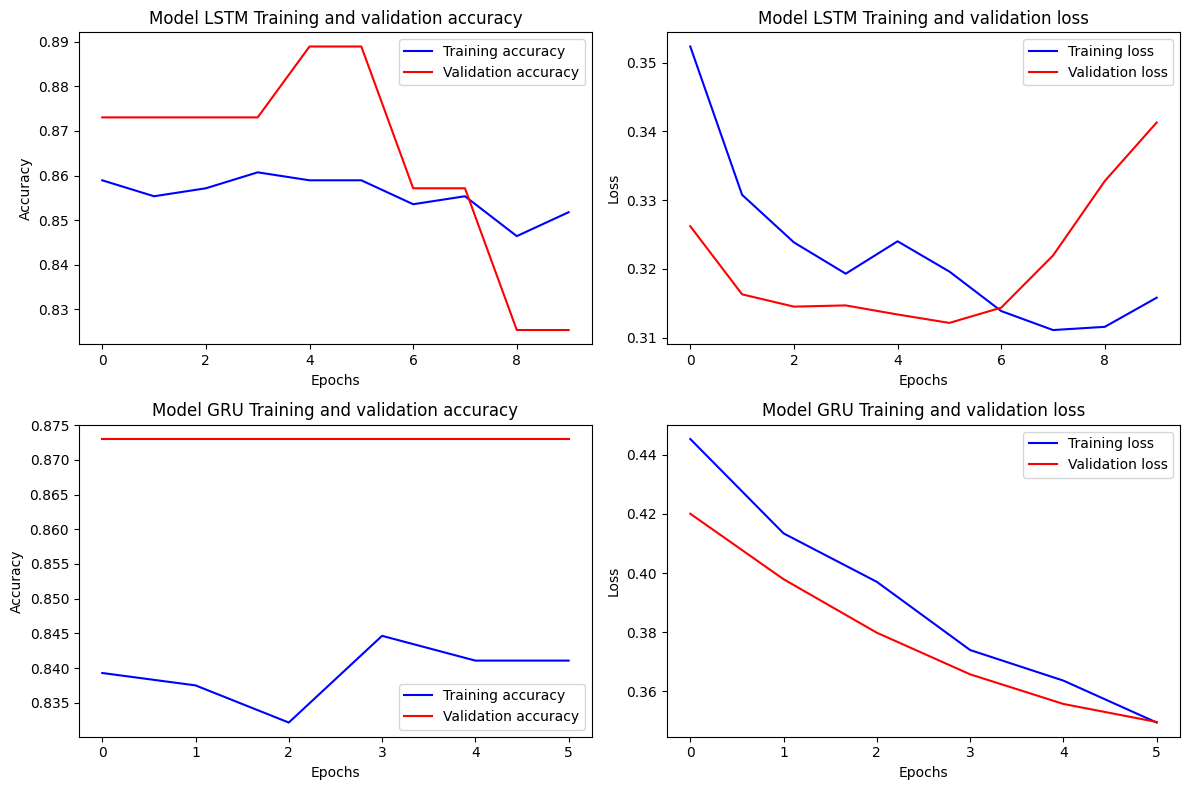

In [115]:
num_models = len(models)

plt.figure(figsize=(12, 4*num_models))

for i, history in enumerate(histories):
    plt.subplot(num_models, 2, 2*i+1)
    plt.plot(history.history['accuracy'], 'b', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'r', label='Validation accuracy')
    plt.title(f'Model {model_names[i]} Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(num_models, 2, 2*i+2)
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title(f'Model {model_names[i]} Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()


### `Assign old Models`

In [116]:
# old_model = load_model('model.h5')
# models.append(old_model)
# model_names.append('Old Model')

### `Predict`

In [117]:
# SENTIMENT
POSITIVE = "Positif"
NEGATIVE = "Negatif"

In [118]:
def decode_sentiment(score):
    return NEGATIVE if score <= 0.4 else POSITIVE

def predict(text):
    for i, model in enumerate(models):
        x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
        score = model.predict([x_test])[0][0]
        label = decode_sentiment(score)
    
        print(f"{model_names[i]}\nSentiment: {label}\nScore: {score}")

In [131]:
predicts_pos = ['Dukung Pragibs', 'Dukung Prabowo', 'SBY']
predicts_neg = ['Prabowo tidak seperti Ganjar', 'Prabowo Blunder', 'HAM']

In [132]:
for i in predicts_pos:
    print(f"==> Text: {i}")
    predict(i)
    print("")

==> Text: Dukung Pragibs
1/1 [==============================] - 0s 41ms/step
LSTM
Sentiment: Positif
Score: 0.7324881553649902
1/1 [==============================] - 0s 33ms/step
GRU
Sentiment: Positif
Score: 0.6662770509719849

==> Text: Dukung Prabowo
1/1 [==============================] - 0s 48ms/step
LSTM
Sentiment: Positif
Score: 0.6101225018501282
1/1 [==============================] - 0s 35ms/step
GRU
Sentiment: Negatif
Score: 0.3453702926635742

==> Text: SBY
1/1 [==============================] - 0s 38ms/step
LSTM
Sentiment: Positif
Score: 0.4897293448448181
1/1 [==============================] - 0s 35ms/step
GRU
Sentiment: Positif
Score: 0.4213307201862335



In [133]:
for i in predicts_neg:
    print(f"==> Text: {i}")
    predict(i)
    print("")

==> Text: Prabowo tidak seperti Ganjar
1/1 [==============================] - 0s 41ms/step
LSTM
Sentiment: Negatif
Score: 0.20109432935714722
1/1 [==============================] - 0s 34ms/step
GRU
Sentiment: Negatif
Score: 0.10077167302370071

==> Text: Prabowo Blunder
1/1 [==============================] - 0s 39ms/step
LSTM
Sentiment: Negatif
Score: 0.16486303508281708
1/1 [==============================] - 0s 41ms/step
GRU
Sentiment: Negatif
Score: 0.06816049665212631

==> Text: HAM
1/1 [==============================] - 0s 45ms/step
LSTM
Sentiment: Negatif
Score: 0.3715466558933258
1/1 [==============================] - 0s 52ms/step
GRU
Sentiment: Negatif
Score: 0.2223086953163147



### `Confusion Matrix`

In [122]:
x_test_tensor

<tf.Tensor: shape=(267, 100), dtype=int32, numpy=
array([[   0,    0,    0, ...,   40,    8,    9],
       [   0,    0,    0, ...,  464, 1450, 1516],
       [   0,    0,    0, ...,  633,  393,   20],
       ...,
       [   0,    0,    0, ...,    3,    5, 1022],
       [   0,    0,    0, ..., 1615, 1120,   58],
       [   0,    0,    0, ...,   34,   37,  174]])>

In [123]:
y_preds = []
for i in models:
    y_pred = i.predict(x_test_tensor)
    binary_predictions = ["positif" if prob > 0.4 else "negatif" for prob in y_pred]
    y_preds.append(binary_predictions)
    print(len(y_pred))

7/9 [======================>.......] - ETA: 0s

9/9 [==============================] - 0s 42ms/step
267
9/9 [==============================] - 0s 29ms/step
267


In [124]:
y_test = list(df_test.label)
y_test[:3]

['positif', 'positif', 'negatif']

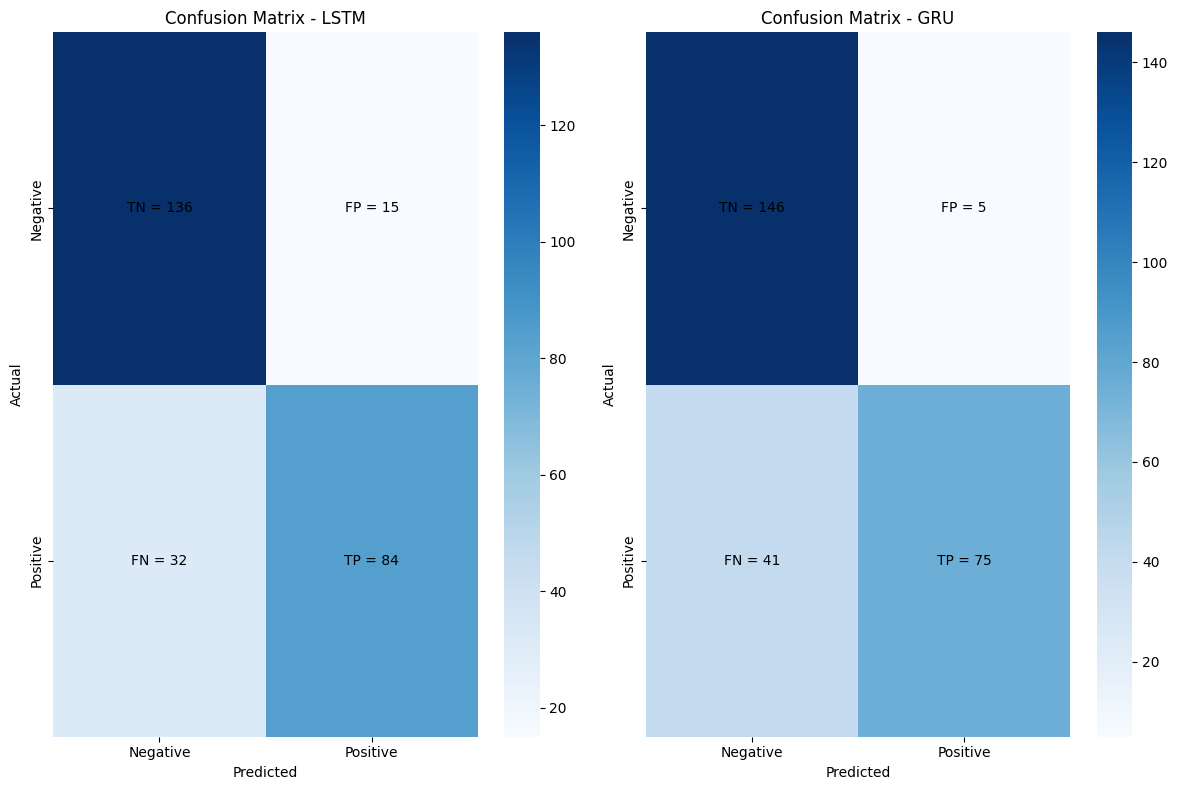

In [125]:
display_confusion_heatmap(y_test, y_preds, model_names)

### `Test Accuracy`

In [126]:
for i, y_pred in enumerate(y_preds):
    acc = check_test_accuracy(y_pred, y_test)
    print(f"Model: {model_names[i]} - Test accuracy: {acc}")

Model: LSTM - Test accuracy: 0.8239700374531835
Model: GRU - Test accuracy: 0.8277153558052435


### `Save Model`

In [127]:
# # EXPORT
# KERAS_MODEL = "model.h5"
# WORD2VEC_MODEL = "model.w2v"
# TOKENIZER_MODEL = "tokenizer.pkl"
# ENCODER_MODEL = "encoder.pkl"

In [128]:
# import pickle

In [129]:
# model.save(KERAS_MODEL)
# w2v_model.save(WORD2VEC_MODEL)
# pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)